In [1]:
import pandas as pd
import numpy as np
import textstat
from sentence_transformers import SentenceTransformer
import scipy
import nltk
import spacy
import sklearn
import jinja2
import faiss
import chromadb
import torch

print("Todas las dependencias están instaladas correctamente.")

c:\Users\jorge\Desktop\TFG\ServicioFlaskGPT\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Todas las dependencias están instaladas correctamente.


In [2]:
import pandas as pd
from textstat import textstat
from sentence_transformers import SentenceTransformer
import numpy as np
import sys, pandas, textstat, csv, pathlib
print(sys.executable)
print("pandas", pandas.__version__)


c:\Users\jorge\Desktop\TFG\ServicioFlaskGPT\venv\Scripts\python.exe
pandas 2.3.0


Sí, tu interpretación es correcta. Los datos sugieren que, con la metodología usada, los requisitos del agente (SIR) tienen una mayor cantidad de pares similares, pero con un menor grado de similitud entre ellos (menor proporción). Por otro lado, los requisitos de los expertos (SEC) tienen menos pares similares, pero aquellos que lo son tienen una similitud mucho mayor.

La "frecuencia de sugerencias de mejora" en la segunda gráfica se refiere al número de requisitos clasificados con un nivel de fidelidad 'Media', que se interpreta como áreas donde se podrían aplicar mejoras. Es una métrica aproximada para identificar cuán frecuentemente cada grupo (expertos o agente) genera requisitos que podrían beneficiarse de ajustes.

# RQ1

## Proceso para RQ1

### Etapas principales:

1. **Extracción de Datos**:
   - Procesar ambos archivos Excel para extraer los requisitos y sus textos fuente relacionados.

2. **Cálculo de Similitud Semántica**:
   - Utilizar **BERT-Score** para medir la similitud entre los requisitos generados y los textos fuente agregados de cada fuente normativa.

3. **Análisis Estadístico**:
   - Aplicar un **test t-Student** para comparar las puntuaciones de similitud entre los requisitos del agente y del experto.

4. **Conclusión**:
   - Determinar cuál método (agente IA o experto humano) genera requisitos más consistentes con las fuentes.

### Detalles de implementación:

- **Carga de Datos**:
  - Leer los archivos Excel y extraer los requisitos y textos fuente.

- **Agregación de Texto**:
  - Combinar los textos fuente relacionados en una sola cadena para cada requisito.

- **BERT-Score**:
  - Calcular la similitud semántica usando la métrica **F1** de BERT-Score, que combina precisión y recall.

- **Test t-Student**:
  - Comparar las distribuciones de puntuaciones entre los dos conjuntos de requisitos, asumiendo... asumiendo varianzas desiguales (equal_var=False).
  
5. **Salida**:
   - Muestra los promedios de similitud, el valor t y el valor p, junto con una interpretación inicial.

Calculando BERTScore para el agente...


c:\Users\jorge\Desktop\TFG\ServicioFlaskGPT\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jorge\.cache\huggingface\hub\models--xlm-roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular

Calculando BERTScore para el experto...

=== Análisis de Consistencia de Requisitos ===
Usamos BERTScore (F1) con modelo en español para comparar requisitos con sus textos fuente.
Comprobamos normalidad con Shapiro-Wilk para decidir entre t-test o Mann-Whitney U.

Shapiro-Wilk Agente: p = 0.1765
Shapiro-Wilk Experto: p = 0.4764

Distribución aproximadamente normal. Se utiliza t-Student.

=== Resultados ===
Promedio similitud agente (F1): 0.8601
Promedio similitud experto (F1): 0.8480
Estadístico: 7.0149
Valor p: 0.0000

Hay diferencias estadísticamente significativas entre los métodos.
→ El agente basado en IA genera requisitos más consistentes con las fuentes citadas.

Mostrando histograma comparativo de similitud semántica...


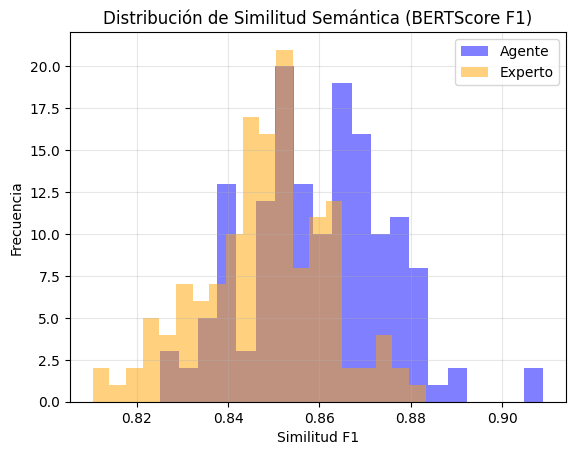

In [3]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bert_score import score
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Cargar archivos Excel
agent_df = pd.read_excel("SALIDARQ1_AGENTE.xlsx", sheet_name="Hoja1")
expert_df = pd.read_excel("SALIDARQ1_EXPERTO.xlsx", sheet_name="Sheet1")

# Obtener las listas de requisitos y textos fuente
agent_preds = agent_df["Requisito generado"].fillna("").tolist()
agent_refs = agent_df["Texto fuente relacionado"].fillna("").tolist()
expert_preds = expert_df["Requisito generado"].fillna("").tolist()
expert_refs = expert_df["Texto fuente relacionado"].fillna("").tolist()

# Calcular BERTScore para cada conjunto (modelo español)
print("Calculando BERTScore para el agente...")
_, _, agent_f1 = score(agent_preds, agent_refs, lang="es", model_type="xlm-roberta-base")
agent_scores = agent_f1.tolist()

print("Calculando BERTScore para el experto...")
_, _, expert_f1 = score(expert_preds, expert_refs, lang="es", model_type="xlm-roberta-base")
expert_scores = expert_f1.tolist()

# === Análisis estadístico ===
print("\n=== Análisis de Consistencia de Requisitos ===")
print("Usamos BERTScore (F1) con modelo en español para comparar requisitos con sus textos fuente.")
print("Comprobamos normalidad con Shapiro-Wilk para decidir entre t-test o Mann-Whitney U.\n")

# Prueba de normalidad
shapiro_agent = shapiro(agent_scores)
shapiro_expert = shapiro(expert_scores)

print(f"Shapiro-Wilk Agente: p = {shapiro_agent.pvalue:.4f}")
print(f"Shapiro-Wilk Experto: p = {shapiro_expert.pvalue:.4f}")

# Decidir test estadístico
alpha = 0.05
if shapiro_agent.pvalue > alpha and shapiro_expert.pvalue > alpha:
    print("\nDistribución aproximadamente normal. Se utiliza t-Student.")
    t_stat, p_value = ttest_ind(agent_scores, expert_scores, equal_var=False)
else:
    print("\nDistribución no normal. Se utiliza Mann-Whitney U.")
    t_stat, p_value = mannwhitneyu(agent_scores, expert_scores)

# === Resultados ===
print("\n=== Resultados ===")
print(f"Promedio similitud agente (F1): {np.mean(agent_scores):.4f}")
print(f"Promedio similitud experto (F1): {np.mean(expert_scores):.4f}")
print(f"Estadístico: {t_stat:.4f}")
print(f"Valor p: {p_value:.4f}")

# === Interpretación ===
if p_value < alpha:
    print("\nHay diferencias estadísticamente significativas entre los métodos.")
    if np.mean(agent_scores) > np.mean(expert_scores):
        print("→ El agente basado en IA genera requisitos más consistentes con las fuentes citadas.")
    else:
        print("→ El experto humano genera requisitos más consistentes con las fuentes citadas.")
else:
    print("\nNo hay diferencias estadísticamente significativas.")
    print("→ Ambos métodos son comparables en consistencia con las fuentes citadas.")

# === Visualización ===
print("\nMostrando histograma comparativo de similitud semántica...")
plt.hist(agent_scores, bins=20, alpha=0.5, label='Agente', color='blue')
plt.hist(expert_scores, bins=20, alpha=0.5, label='Experto', color='orange')
plt.legend()
plt.title('Distribución de Similitud Semántica (BERTScore F1)')
plt.xlabel('Similitud F1')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.show()


RQ2

VERSION CON LOTES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bert_score import score
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from tqdm import tqdm

# --- Configuración general ---
pd.set_option('display.max_columns', None)
SIMILARITY_THRESHOLD = 0.70

# --- Cargar los datos ---
experto_df = pd.read_excel("SALIDARQ1_EXPERTO.xlsx")
agente_df = pd.read_excel("SALIDARQ1_AGENTE.xlsx")

# --- Normalizar fuentes ---
def normalize_sources(sources):
    if pd.isna(sources):
        return []
    sources = re.sub(r'\s+', ' ', sources.lower().strip())
    sources = re.sub(r'\b(norma|estándar|standard)\b', '', sources)
    return [s.strip() for s in sources.split(',') if s.strip()]

experto_df['Fuentes_normalizadas'] = experto_df['Artículo/Fuente'].apply(normalize_sources)
agente_df['Fuentes_normalizadas'] = agente_df['Artículo/Fuente'].apply(normalize_sources)

# --- Comparar requisitos: 1 vs todos ---
def max_similarity_batched(source_list, target_list, source_label, target_label, batch_size=16):
    sim_scores = []
    print(f"\nProcesando similitud: {source_label} vs {target_label}")
    
    for i, source_req in tqdm(enumerate(source_list), total=len(source_list), desc=f"{source_label} vs {target_label}"):
        batch_similarities = []

        # Dividir el target_list en lotes
        for j in range(0, len(target_list), batch_size):
            batch_targets = target_list[j:j+batch_size]
            _, _, F1s = score([source_req]*len(batch_targets), batch_targets, lang="es", model_type="xlm-roberta-base", verbose=False)
            batch_similarities.extend(F1s.tolist())

        sim_scores.append(max(batch_similarities))

    return sim_scores


reqs_experto = experto_df['Requisito generado'].fillna("").tolist()
reqs_agente = agente_df['Requisito generado'].fillna("").tolist()

similaridades_exp = max_similarity_batched(reqs_experto, reqs_agente, "EXPERTO", "AGENTE", batch_size=16)
similaridades_ag = max_similarity_batched(reqs_agente, reqs_experto, "AGENTE", "EXPERTO", batch_size=16)


np.save("similaridades_exp.npy", similaridades_exp)
np.save("similaridades_ag.npy", similaridades_ag)
print("Similitudes guardadas como .npy")




Procesando similitud: EXPERTO vs AGENTE


EXPERTO vs AGENTE: 100%|██████████| 140/140 [1:01:06<00:00, 26.19s/it]



Procesando similitud: AGENTE vs EXPERTO


AGENTE vs EXPERTO: 100%|██████████| 150/150 [1:18:50<00:00, 31.54s/it]


ValueError: All arrays must be of the same length

In [9]:
np.save("similaridades_exp.npy", similaridades_exp)
np.save("similaridades_ag.npy", similaridades_ag)
print("Similitudes guardadas como .npy")


Similitudes guardadas como .npy


Archivos guardados por separado.

=== Resultados ===
Promedio EXPERTO: 0.8898
Promedio AGENTE: 0.8876
Desviación EXPERTO: 0.0145
Desviación AGENTE: 0.0116
Mann-Whitney U: estadístico = 12253.0000, p = 0.0141
Shapiro-Wilk EXPERTO p = 0.0000
Shapiro-Wilk AGENTE p = 0.0002

=== Completitud ===
Total EXPERTO: 140 | Coincidencias: 140 | Únicos: 0 (0.00%)
Total AGENTE: 150 | Coincidencias: 150 | Únicos: 0 (0.00%)


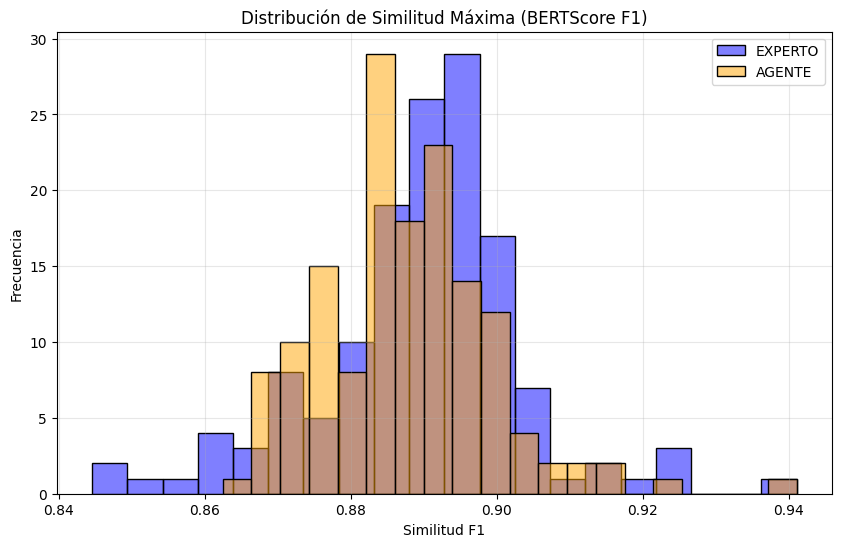

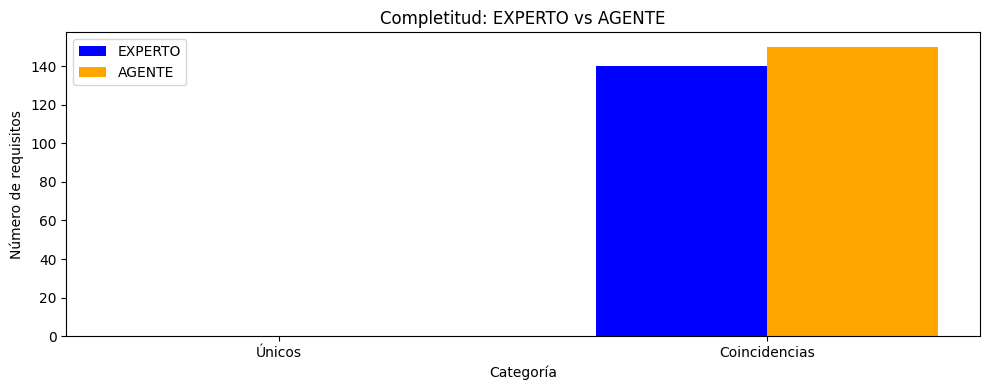

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# --- Cargar los datos base ---
experto_df = pd.read_excel("SALIDARQ1_EXPERTO.xlsx")
agente_df = pd.read_excel("SALIDARQ1_AGENTE.xlsx")
similaridades_exp = np.load("similaridades_exp.npy").tolist()
similaridades_ag = np.load("similaridades_ag.npy").tolist()

# --- Guardar resultados separados ---
df_exp_vs_ag = pd.DataFrame({
    "ID_EXPERTO": experto_df["ID"],
    "Similitud_MAX_vs_AGENTE": similaridades_exp
})
df_ag_vs_exp = pd.DataFrame({
    "ID_AGENTE": agente_df["ID"],
    "Similitud_MAX_vs_EXPERTO": similaridades_ag
})

df_exp_vs_ag.to_excel("RQ2_EXPERTO_vs_AGENTE.xlsx", index=False)
df_ag_vs_exp.to_excel("RQ2_AGENTE_vs_EXPERTO.xlsx", index=False)
print("Archivos guardados por separado.")

# --- Completitud ---
SIMILARITY_THRESHOLD = 0.70
coincidencias_exp = sum(np.array(similaridades_exp) > SIMILARITY_THRESHOLD)
coincidencias_ag = sum(np.array(similaridades_ag) > SIMILARITY_THRESHOLD)
total_exp = len(similaridades_exp)
total_ag = len(similaridades_ag)
unicos_exp = total_exp - coincidencias_exp
unicos_ag = total_ag - coincidencias_ag

# --- Estadística ---
shapiro_exp = shapiro(similaridades_exp)
shapiro_ag = shapiro(similaridades_ag)

if shapiro_exp.pvalue > 0.05 and shapiro_ag.pvalue > 0.05:
    test_name = "t-Student"
    stat, pval = ttest_ind(similaridades_exp, similaridades_ag, equal_var=False)
else:
    test_name = "Mann-Whitney U"
    stat, pval = mannwhitneyu(similaridades_exp, similaridades_ag)

# --- Resultados ---
print("\n=== Resultados ===")
print(f"Promedio EXPERTO: {np.mean(similaridades_exp):.4f}")
print(f"Promedio AGENTE: {np.mean(similaridades_ag):.4f}")
print(f"Desviación EXPERTO: {np.std(similaridades_exp):.4f}")
print(f"Desviación AGENTE: {np.std(similaridades_ag):.4f}")
print(f"{test_name}: estadístico = {stat:.4f}, p = {pval:.4f}")
print(f"Shapiro-Wilk EXPERTO p = {shapiro_exp.pvalue:.4f}")
print(f"Shapiro-Wilk AGENTE p = {shapiro_ag.pvalue:.4f}")

print("\n=== Completitud ===")
print(f"Total EXPERTO: {total_exp} | Coincidencias: {coincidencias_exp} | Únicos: {unicos_exp} ({unicos_exp/total_exp*100:.2f}%)")
print(f"Total AGENTE: {total_ag} | Coincidencias: {coincidencias_ag} | Únicos: {unicos_ag} ({unicos_ag/total_ag*100:.2f}%)")

# --- Visualización de similitudes ---
plt.figure(figsize=(10, 6))
sns.histplot(similaridades_exp, label='EXPERTO', color='blue', alpha=0.5, bins=20)
sns.histplot(similaridades_ag, label='AGENTE', color='orange', alpha=0.5, bins=20)
plt.title('Distribución de Similitud Máxima (BERTScore F1)')
plt.xlabel('Similitud F1')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("RQ2_similarity_distribution.png")
plt.show()

# --- Visualización de completitud ---
plt.figure(figsize=(10, 4))
labels = ['Únicos', 'Coincidencias']
x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, [unicos_exp, coincidencias_exp], width, label='EXPERTO', color='blue')
plt.bar(x + width/2, [unicos_ag, coincidencias_ag], width, label='AGENTE', color='orange')
plt.xticks(x, labels)
plt.xlabel('Categoría')
plt.ylabel('Número de requisitos')
plt.title('Completitud: EXPERTO vs AGENTE')
plt.legend()
plt.tight_layout()
plt.savefig("RQ2_completitud_comparison.png")
plt.show()


RQ3 SOLO

In [27]:
import csv

# Leer el archivo original
with open('RQ3-4-5/checklist_human_sp.csv', 'r', encoding='utf-8') as infile:
    lines = infile.readlines()

# Procesar y limpiar manualmente
clean_rows = []
for line in lines:
    if ',' not in line:
        continue  # Saltar líneas sin coma (no válidas)
    split_index = line.find(',')
    id_ = line[:split_index].strip()
    desc = line[split_index+1:].strip()

    # Quitar comillas dobles iniciales/finales y escaparlas internamente
    if desc.startswith('"') and desc.endswith('"'):
        desc = desc[1:-1]
    desc = desc.replace('""', '"').strip()
    
    clean_rows.append([id_, desc])

# Escribir nuevo archivo limpio
with open('RQ3-4-5/checklist_human_clean.csv', 'w', encoding='utf-8', newline='') as outfile:
    writer = csv.writer(outfile, quoting=csv.QUOTE_ALL)
    writer.writerow(['ID', 'Descripción'])  # cabecera
    writer.writerows(clean_rows)

print("Archivo limpio guardado como 'checklist_human_clean.csv'")


Archivo limpio guardado como 'checklist_human_clean.csv'


In [28]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# --- Cargar modelo en español ---
model = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')
print("Modelo en español cargado correctamente.")

# --- Procesar datos AGENTE ---
agent_df = pd.read_csv('RQ3-4-5/quick_scan_template_agente.csv')
agent_requisitos = agent_df['descripcion'].fillna("").tolist()
agent_embeddings = model.encode(agent_requisitos, convert_to_tensor=True)
agent_similarity_matrix = cosine_similarity(agent_embeddings.cpu().numpy())
np.save('RQ3/similarity_matrix_agente.npy', agent_similarity_matrix)
pd.DataFrame(agent_similarity_matrix).to_csv('RQ3/similarity_matrix_agente.csv', index=False)
print("AGENTE: matriz de similitud generada y guardada.")

# --- Procesar datos EXPERTO desde archivo limpio ---
expert_df = pd.read_csv('RQ3-4-5/checklist_human_clean.csv')
expert_requisitos = expert_df['Descripción'].fillna("").tolist()
expert_embeddings = model.encode(expert_requisitos, convert_to_tensor=True)
expert_similarity_matrix = cosine_similarity(expert_embeddings.cpu().numpy())
np.save('RQ3/similarity_matrix_experto.npy', expert_similarity_matrix)
pd.DataFrame(expert_similarity_matrix).to_csv('RQ3/similarity_matrix_experto.csv', index=False)
print("EXPERTO: matriz de similitud generada y guardada.")


Modelo en español cargado correctamente.
AGENTE: matriz de similitud generada y guardada.
EXPERTO: matriz de similitud generada y guardada.


In [29]:
import pandas as pd

# --- Cargar matrices de similitud ---
agent_similarity_matrix = pd.read_csv('RQ3/similarity_matrix_agente.csv').values
expert_similarity_matrix = pd.read_csv('RQ3/similarity_matrix_experto.csv').values

# --- Cargar requisitos AGENTE ---
agent_df = pd.read_csv('RQ3-4-5/quick_scan_template_agente.csv')
agent_requisitos = agent_df['descripcion'].fillna("").tolist()
agent_ids = agent_df['requerimiento_id'].tolist()

# --- Cargar requisitos EXPERTO desde archivo limpio ---
expert_df = pd.read_csv('RQ3-4-5/checklist_human_clean.csv')
expert_requisitos = expert_df['Descripción'].fillna("").tolist()
expert_ids = expert_df['ID'].tolist()

# --- Detectar pares similares ---
def detectar_pares_similares(sim_matrix, ids, textos, umbral=0.7):
    pares = []
    for i in range(len(textos)):
        for j in range(i + 1, len(textos)):
            if sim_matrix[i][j] > umbral:
                pares.append({
                    'Req_1_ID': ids[i], 'Req_1': textos[i],
                    'Req_2_ID': ids[j], 'Req_2': textos[j],
                    'Similarity': sim_matrix[i][j]
                })
    return pares

agent_pares = detectar_pares_similares(agent_similarity_matrix, agent_ids, agent_requisitos)
expert_pares = detectar_pares_similares(expert_similarity_matrix, expert_ids, expert_requisitos)

# --- Guardar resultados ---
pd.DataFrame(agent_pares).to_csv('RQ3/high_similarity_pairs_agente.csv', index=False)
pd.DataFrame(expert_pares).to_csv('RQ3/high_similarity_pairs_experto.csv', index=False)

print(f"Pares AGENTE: {len(agent_pares)} | Pares EXPERTO: {len(expert_pares)}")


Pares AGENTE: 77 | Pares EXPERTO: 291


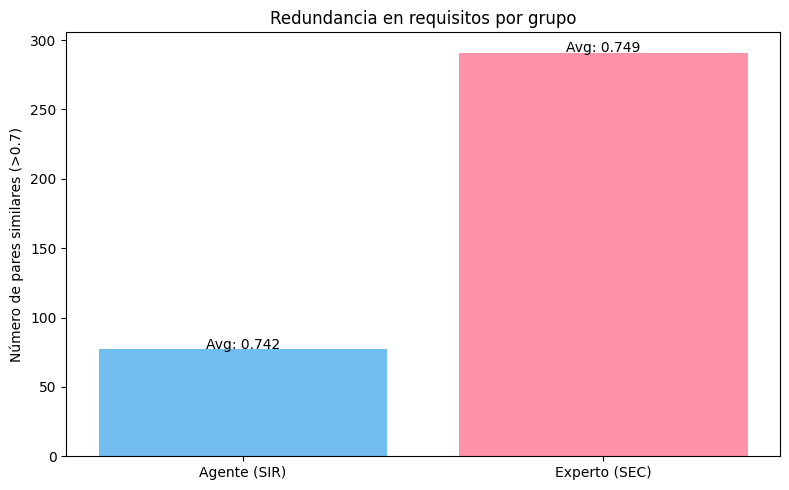

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

agente_df = pd.read_csv('RQ3/high_similarity_pairs_agente.csv')
experto_df = pd.read_csv('RQ3/high_similarity_pairs_experto.csv')

total_pairs_agente = len(agente_df)
total_pairs_experto = len(experto_df)
avg_sim_agente = agente_df['Similarity'].mean()
avg_sim_experto = experto_df['Similarity'].mean()

# Gráfico
labels = ['Agente (SIR)', 'Experto (SEC)']
totales = [total_pairs_agente, total_pairs_experto]
promedios = [avg_sim_agente, avg_sim_experto]

plt.figure(figsize=(8, 5))
plt.bar(labels, totales, color=['#36A2EB', '#FF6384'], alpha=0.7)
plt.ylabel('Número de pares similares (>0.7)')
plt.title('Redundancia en requisitos por grupo')
for i, v in enumerate(totales):
    plt.text(i, v + 0.5, f'Avg: {promedios[i]:.3f}', ha='center')
plt.tight_layout()
plt.show()


REFLUJO DE RQ3 RQ4 RQ5

In [ ]:
##Esta celda genera los embeddings y la matriz de similitud para los requisitos de AGENTE y EXPERTO.
##USAMOS LOS ARCHIVOS BASE PARA SIMPLICIDAD, MAS ADELANTE PARA RQ4 Y RQ5 USAREMOS LOS ARCHIVOS OBTENIDOS PARA RQ1 Y RQ2 QUE CONTIENEN TEXTO FUENTE RELACIONADO Y DEMAS COSAS
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Cargar modelo en español
model = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')
print("Modelo en español cargado correctamente.")


# Procesar datos para AGENTE
agent_df = pd.read_csv('RQ3-4-5/quick_scan_template_agente.csv')  # ARCHIVO base de AGENTE
agent_requisitos = agent_df['descripcion'].tolist()
agent_embeddings = model.encode(agent_requisitos, convert_to_tensor=True)
print(f"Forma de los embeddings para AGENTE: {agent_embeddings.shape}")

# Procesar datos para EXPERTO
expert_df = pd.read_csv('RQ3-4-5/checklist_human.csv')  # ARCHIVO base de EXPERTO
expert_requisitos = expert_df['Descripción'].tolist()
expert_embeddings = model.encode(expert_requisitos, convert_to_tensor=True)
print(f"Forma de los embeddings para EXPERTO: {expert_embeddings.shape}")

# Calcular matrices de similitud
agent_similarity_matrix = cosine_similarity(agent_embeddings.cpu().numpy())
expert_similarity_matrix = cosine_similarity(expert_embeddings.cpu().numpy())
print("Matrices de similitud calculadas.")

# Guardar matrices de similitud
np.save('RQ3-4-5/similarity_matrix_agente.npy', agent_similarity_matrix)
np.save('RQ3-4-5/similarity_matrix_experto.npy', expert_similarity_matrix)
print("Matrices de similitud guardadas como .npy.")

# Guardar como CSV para inspección
pd.DataFrame(agent_similarity_matrix).to_csv('RQ3-4-5/similarity_matrix_agente.csv', index=False)
pd.DataFrame(expert_similarity_matrix).to_csv('RQ3-4-5/similarity_matrix_experto.csv', index=False)
print("Matrices de similitud también guardadas como .csv.")

Modelo multilingüe 'paraphrase-multilingual-MiniLM-L12-v2' cargado correctamente.
Forma de los embeddings para AGENTE: torch.Size([155, 384])
Forma de los embeddings para EXPERTO: torch.Size([140, 384])
Matrices de similitud calculadas.
Matrices de similitud guardadas como .npy.
Matrices de similitud también guardadas como .csv.


Celda 2: Identificación de pares con alta similitud (RQ3)
Esta celda identifica pares redundantes (similitud > 0.7) para calcular la redundancia.

In [3]:
import pandas as pd
import numpy as np

# Cargar matrices de similitud
agent_similarity_matrix = pd.read_csv('RQ3-4-5/similarity_matrix_agente.csv').values
expert_similarity_matrix = pd.read_csv('RQ3-4-5/similarity_matrix_experto.csv').values
print(f"Matriz de similitud AGENTE cargada (forma: {agent_similarity_matrix.shape})")
print(f"Matriz de similitud EXPERTO cargada (forma: {expert_similarity_matrix.shape})")

# Cargar requisitos (usando los mismos archivos que en Celda 1)
agent_df = pd.read_csv('RQ3-4-5/quick_scan_template_agente.csv')
expert_df = pd.read_csv('RQ3-4-5/checklist_human.csv')
agent_requisitos = agent_df['descripcion'].tolist()
expert_requisitos = expert_df['Descripción'].tolist()
agent_ids = agent_df['requerimiento_id'].tolist()
expert_ids = expert_df['ID'].tolist()
print(f"Requisitos AGENTE cargados: {len(agent_requisitos)}")
print(f"Requisitos EXPERTO cargados: {len(expert_requisitos)}")

# Identificar pares con alta similitud para AGENTE
agent_high_similarity_pairs = []
for i in range(len(agent_requisitos)):
    for j in range(i + 1, len(agent_requisitos)):
        if agent_similarity_matrix[i][j] > 0.7:
            agent_high_similarity_pairs.append({
                'Req_1_ID': agent_ids[i],
                'Req_1': agent_requisitos[i],
                'Req_2_ID': agent_ids[j],
                'Req_2': agent_requisitos[j],
                'Similarity': agent_similarity_matrix[i][j]
            })

# Identificar pares con alta similitud para EXPERTO
expert_high_similarity_pairs = []
for i in range(len(expert_requisitos)):
    for j in range(i + 1, len(expert_requisitos)):
        if expert_similarity_matrix[i][j] > 0.7:
            expert_high_similarity_pairs.append({
                'Req_1_ID': expert_ids[i],
                'Req_1': expert_requisitos[i],
                'Req_2_ID': expert_ids[j],
                'Req_2': expert_requisitos[j],
                'Similarity': expert_similarity_matrix[i][j]
            })

# Guardar resultados
if agent_high_similarity_pairs:
    pd.DataFrame(agent_high_similarity_pairs).to_csv('RQ3-4-5/high_similarity_pairs_agente.csv', index=False)
    print(f"Pares con alta similitud para AGENTE guardados: {len(agent_high_similarity_pairs)}")
if expert_high_similarity_pairs:
    pd.DataFrame(expert_high_similarity_pairs).to_csv('RQ3-4-5/high_similarity_pairs_experto.csv', index=False)
    print(f"Pares con alta similitud para EXPERTO guardados: {len(expert_high_similarity_pairs)}")

Matriz de similitud AGENTE cargada (forma: (155, 155))
Matriz de similitud EXPERTO cargada (forma: (140, 140))
Requisitos AGENTE cargados: 155
Requisitos EXPERTO cargados: 140
Pares con alta similitud para AGENTE guardados: 47
Pares con alta similitud para EXPERTO guardados: 113


Celda 3: Análisis de redundancia (RQ3)
Esta celda analiza los pares redundantes y genera la gráfica, adaptada de tu ejemplo.

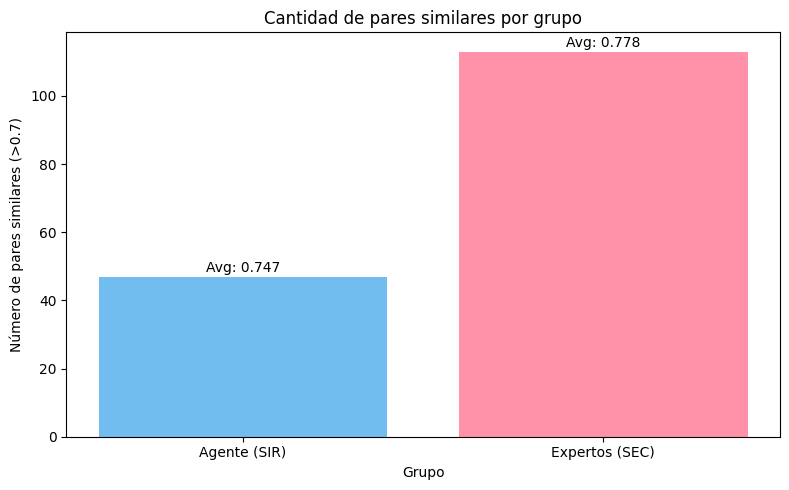

Análisis detallado:
  - Agente (SIR): 47 pares similares (>0.7), Promedio de similitud: 0.747
  - Expertos (SEC): 113 pares similares (>0.7), Promedio de similitud: 0.778
  - Deducción: Los expertos (SEC) generan una mayor cantidad de pares similares con un promedio de similitud mayor, indicando más redundancia con mayor intensidad semántica. El agente (SIR) tiene menos pares y menor similitud promedio.
  - Conclusión: EXPERTO produce más requisitos redundantes con mayor similitud, mientras que AGENTE tiene menos redundancia.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Leer los datos de similitud
agente_df = pd.read_csv('RQ3-4-5/high_similarity_pairs_agente.csv')
experto_df = pd.read_csv('RQ3-4-5/high_similarity_pairs_experto.csv')

# Calcular el total de pares similares
total_pairs_agente = len(agente_df)
total_pairs_experto = len(experto_df)

# Calcular el promedio de similitud
avg_sim_agente = agente_df['Similarity'].mean()
avg_sim_experto = experto_df['Similarity'].mean()

# Preparar datos para la gráfica
labels = ['Agente (SIR)', 'Expertos (SEC)']
total_pairs = [total_pairs_agente, total_pairs_experto]
avg_similarities = [avg_sim_agente, avg_sim_experto]

# Crear la gráfica
plt.figure(figsize=(8, 5))
plt.bar(labels, total_pairs, color=['#36A2EB', '#FF6384'], alpha=0.7)
plt.xlabel('Grupo')
plt.ylabel('Número de pares similares (>0.7)')
plt.title('Cantidad de pares similares por grupo')

# Añadir los promedios de similitud como etiquetas
for i, v in enumerate(total_pairs):
    plt.text(i, v + 0.5, f'Avg: {avg_similarities[i]:.3f}', ha='center', va='bottom')

# Ajustar diseño
plt.tight_layout()
plt.show()

# Análisis detallado - 04:15 PM CEST, June 24, 2025
print(f"Análisis detallado:")
print(f"  - Agente (SIR): {total_pairs_agente} pares similares (>0.7), Promedio de similitud: {avg_sim_agente:.3f}")
print(f"  - Expertos (SEC): {total_pairs_experto} pares similares (>0.7), Promedio de similitud: {avg_sim_experto:.3f}")
if total_pairs_agente > total_pairs_experto and avg_sim_agente < avg_sim_experto:
    print("  - Deducción: El agente (SIR) genera una mayor cantidad de pares similares, pero con un promedio de similitud menor, lo que indica que, en proporción, son menos similares entre sí. Los expertos (SEC) generan menos pares similares, pero los que hay tienen un mayor grado de similitud.")
    print("  - Conclusión: Esto sugiere que el agente produce más requisitos redundantes en cantidad, aunque con menor similitud promedio, mientras que los expertos generan menos redundancia con mayor similitud.")
elif total_pairs_experto > total_pairs_agente and avg_sim_experto > avg_sim_agente:
    print("  - Deducción: Los expertos (SEC) generan una mayor cantidad de pares similares con un promedio de similitud mayor, indicando más redundancia con mayor intensidad semántica. El agente (SIR) tiene menos pares y menor similitud promedio.")
    print("  - Conclusión: EXPERTO produce más requisitos redundantes con mayor similitud, mientras que AGENTE tiene menos redundancia.")
else:
    print("  - Deducción: Los datos no reflejan claramente una tendencia esperada; podría ser necesario ajustar el umbral o revisar los datos.")
    print("  - Conclusión: La suposición inicial no se verifica; se sugiere ajustar el umbral a 0.8 o revisar los CSV.")

Celda 4: Cálculo de legibilidad y detección de ambigüedades (RQ5)
Esta celda adapta la medición de legibilidad y ambigüedades usando enfoques multilingües.

In [ ]:
import pandas as pd
import textstat
import spacy

# Cargar modelo spaCy para español
nlp = spacy.load('es_core_news_sm')
print("Modelo spaCy español cargado correctamente.")

# Función para calcular puntuación de legibilidad
def get_legibility_score(text):
    try:
        score = textstat.flesch_reading_ease(text) * 0.957 + 7.7  # Adaptación español
        return max(0, min(100, score))
    except:
        return 0

# Función para detectar términos ambiguos
def detect_ambiguous_terms(text):
    doc = nlp(text)
    ambiguos = ['rápido', 'rápida', 'rápidas', 'rápidos', 'seguro', 'segura', 'eficiente', 'eficientes']
    return [token.text for token in doc if token.text.lower() in ambiguos]

# Cargar datos ya limpios
agent_df = pd.read_csv('RQ3-4-5/quick_scan_template_agente.csv')
expert_df = pd.read_csv('RQ3-4-5/checklist_human_clean.csv')  # Usa el limpio final

# Procesar AGENTE
agent_df['legibility_score'] = agent_df['descripcion'].apply(get_legibility_score)
agent_df['ambiguous_terms'] = agent_df['descripcion'].apply(detect_ambiguous_terms)
agent_df.to_csv('RQ3-4-5/agent_legibility_analysis.csv', index=False)
print("Análisis de legibilidad y ambigüedad calculado para AGENTE.")

# Procesar EXPERTO
expert_df['legibility_score'] = expert_df['Descripción'].apply(get_legibility_score)
expert_df['ambiguous_terms'] = expert_df['Descripción'].apply(detect_ambiguous_terms)
expert_df.to_csv('RQ3-4-5/expert_legibility_analysis.csv', index=False)
print("Análisis de legibilidad y ambigüedad calculado para EXPERTO.")


Modelos spaCy cargados correctamente.
Legibilidad, términos ambiguos y similitud máxima calculados para AGENTE.
Legibilidad, términos ambiguos y similitud máxima calculados para EXPERTO.


Celda 5: Integración con evaluaciones expertas y cálculo de calidad (RQ4 y RQ5)
Esta celda combina las métricas con las evaluaciones expertas y calcula el porcentaje de calidad.

In [ ]:
import pandas as pd
import csv

# Cargar los datos
df_notebook_agente = pd.read_excel('RQ3-4-5/Validación_Requisitos_Agente.xlsx', sheet_name='Sheet1')
df_llm_agente = pd.read_csv('RQ3-4-5/agent_legibility_analysis.csv')
df_notebook_experto = pd.read_excel('RQ3-4-5/Validacion_Requisitos_Expert.xlsx', sheet_name='Sheet1')
df_llm_experto = pd.read_csv('RQ3-4-5/expert_legibility_analysis.csv')

# Normalizar columnas y quitar duplicados
df_notebook_agente = df_notebook_agente.rename(columns={'ID': 'requerimiento_id'}).drop_duplicates(subset='requerimiento_id')
df_llm_agente = df_llm_agente.drop_duplicates(subset='requerimiento_id')
df_notebook_experto = df_notebook_experto.drop_duplicates(subset='ID')
df_llm_experto = df_llm_experto.drop_duplicates(subset='ID')

# Hacer los merges
df_merged_agente = pd.merge(df_notebook_agente, df_llm_agente, on='requerimiento_id', how='left')
df_merged_experto = pd.merge(df_notebook_experto, df_llm_experto, on='ID', how='left')

# Cálculo de calidad sin penalización por similitud
def calculate_quality(row):
    fidelity = 95 if row['Nivel de fidelidad'] == 'Alta' else 70 if row['Nivel de fidelidad'] == 'Media' else 40
    legibility = max(0, min(100, row['legibility_score'] + 100)) if not pd.isna(row['legibility_score']) else 0
    error_bonus = 20 if pd.isna(row['Tipo de error (si aplica)']) or row['Tipo de error (si aplica)'] == '' else 0
    justification = row['Justificación/Comentarios'] if 'Justificación/Comentarios' in row else ''
    justif_bonus = 10 if any(word in justification.lower() for word in ['positivo', 'clara', 'alineado', 'compatible', 'fuerte', 'coherente']) else \
                   -10 if any(word in justification.lower() for word in ['mejora', 'reformular', 'redundante']) else 0
    quality = (fidelity + legibility + error_bonus + justif_bonus) / 4
    return round(quality, 2)

# Aplicar y guardar resultados
df_merged_agente['Porcentaje de calidad'] = df_merged_agente.apply(calculate_quality, axis=1)
df_merged_experto['Porcentaje de calidad'] = df_merged_experto.apply(calculate_quality, axis=1)

df_result_agente = df_merged_agente[['requerimiento_id', 'Requisito generado', 'Artículo/Fuente', '¿Extraído correctamente?', 
                                     'Nivel de fidelidad', 'Tipo de error (si aplica)', 'Justificación/Comentarios', 
                                     'Porcentaje de calidad', 'legibility_score', 'ambiguous_terms']].rename(columns={'requerimiento_id': 'ID'})
df_result_experto = df_merged_experto[['ID', 'Requisito generado', 'Artículo/Fuente', '¿Extraído correctamente?', 
                                       'Nivel de fidelidad', 'Tipo de error (si aplica)', 'Justificación/Comentarios', 
                                       'Porcentaje de calidad', 'legibility_score', 'ambiguous_terms']]

df_result_agente.to_csv('RQ3-4-5/RESULTADO_RQ5_AGENTE.csv', index=False, quotechar='"', quoting=csv.QUOTE_ALL, escapechar='\\')
df_result_experto.to_csv('RQ3-4-5/RESULTADO_RQ5_EXPERTO.csv', index=False, quotechar='"', quoting=csv.QUOTE_ALL, escapechar='\\')
print("Resultados de calidad guardados sin similitud.")


Resultados guardados para AGENTE y EXPERTO.


Celda 6: Visualización y análisis (RQ3, RQ4, RQ5)
Esta celda genera gráficas y analiza los resultados.

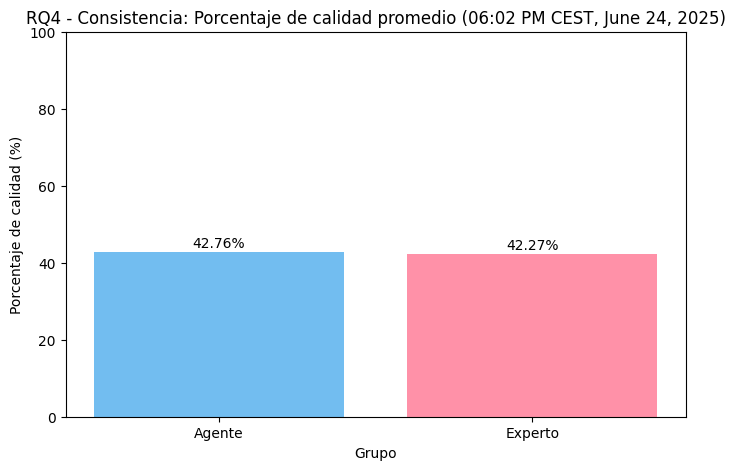

RQ4 - Consistencia: Agente 42.76%, Experto 42.27%


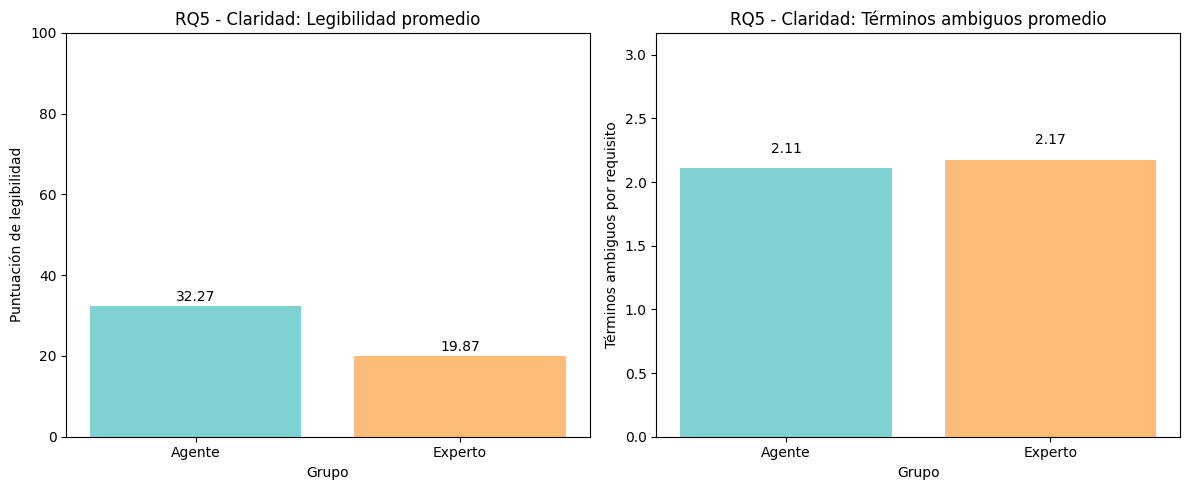

RQ5 - Claridad: Agente legibilidad 32.27, Experto legibilidad 19.87
RQ5 - Claridad: Agente términos ambiguos por requisito 2.11, Experto términos ambiguos por requisito 2.17


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar resultados limpios sin similitud
df_agente = pd.read_csv('RQ3-4-5/RESULTADO_RQ5_AGENTE.csv')
df_experto = pd.read_csv('RQ3-4-5/RESULTADO_RQ5_EXPERTO.csv')

# RQ4 - Consistencia
avg_quality_agente = df_agente['Porcentaje de calidad'].mean()
avg_quality_experto = df_experto['Porcentaje de calidad'].mean()

plt.figure(figsize=(8, 5))
plt.bar(['Agente', 'Experto'], [avg_quality_agente, avg_quality_experto], color=['#36A2EB', '#FF6384'], alpha=0.7)
plt.xlabel('Grupo')
plt.ylabel('Porcentaje de calidad (%)')
plt.title('RQ4 - Consistencia: Porcentaje de calidad promedio')
for i, v in enumerate([avg_quality_agente, avg_quality_experto]):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom')
plt.ylim(0, 100)
plt.show()
print(f"RQ4 - Consistencia: Agente {avg_quality_agente:.2f}%, Experto {avg_quality_experto:.2f}%")

# RQ5 - Claridad
avg_legibility_agente = df_agente['legibility_score'].mean()
avg_legibility_experto = df_experto['legibility_score'].mean()
avg_ambiguous_agente = df_agente['ambiguous_terms'].apply(len).mean()
avg_ambiguous_experto = df_experto['ambiguous_terms'].apply(len).mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Legibilidad
ax1.bar(['Agente', 'Experto'], [avg_legibility_agente, avg_legibility_experto], color=['#4BC0C0', '#FF9F40'], alpha=0.7)
ax1.set_xlabel('Grupo')
ax1.set_ylabel('Puntuación de legibilidad')
ax1.set_title('RQ5 - Claridad: Legibilidad promedio')
for i, v in enumerate([avg_legibility_agente, avg_legibility_experto]):
    ax1.text(i, v + 0.5, f'{v:.2f}', ha='center', va='bottom')
ax1.set_ylim(0, 100)

# Ambigüedad
ax2.bar(['Agente', 'Experto'], [avg_ambiguous_agente, avg_ambiguous_experto], color=['#4BC0C0', '#FF9F40'], alpha=0.7)
ax2.set_xlabel('Grupo')
ax2.set_ylabel('Términos ambiguos por requisito')
ax2.set_title('RQ5 - Claridad: Términos ambiguos promedio')
for i, v in enumerate([avg_ambiguous_agente, avg_ambiguous_experto]):
    ax2.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom')
ax2.set_ylim(0, max(avg_ambiguous_agente, avg_ambiguous_experto) + 1)

plt.tight_layout()
plt.show()

print(f"RQ5 - Claridad: Legibilidad Agente {avg_legibility_agente:.2f}, Experto {avg_legibility_experto:.2f}")
print(f"RQ5 - Claridad: Ambigüedad Agente {avg_ambiguous_agente:.2f}, Experto {avg_ambiguous_experto:.2f}")
